# НОУТБУК 2: ОБУЧЕНИЕ МОДЕЛИ YOLOv8
Детектирование браконьеров на фотоловушках

Этот ноутбук выполняет:
1. Загрузку предобученной модели YOLOv8 Nano
2. Fine-tuning на кастомных данных
3. Мониторинг метрик во время обучения
4. Сохранение лучшей модели
5. Анализ графиков обучения


In [16]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import yaml

# Проверить GPU
print("=" * 70)
print("ПРОВЕРКА ОКРУЖЕНИЯ")
print("=" * 70)

print(f"\n Python версия: {os.sys.version.split()[0]}")
print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA версия: {torch.version.cuda}")
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"Всего VRAM: {total_memory:.2f} ГБ")
else:
    print("️GPU не найдена. Обучение будет на CPU (медленнее)")

ПРОВЕРКА ОКРУЖЕНИЯ

 Python версия: 3.12.3
PyTorch версия: 2.9.1+cpu
CUDA доступна: False
️GPU не найдена. Обучение будет на CPU (медленнее)


# ЧАСТЬ 1: УСТАНОВКА И ИМПОРТ ULTRALYTICS

In [17]:
print("\n" + "=" * 70)
print("УСТАНОВКА ULTRALYTICS")
print("=" * 70 + "\n")

try:
    from ultralytics import YOLO

    print("Ultralytics уже установлена")
except ImportError:
    print("Установка Ultralytics...")
    os.system('pip install ultralytics -q')
    from ultralytics import YOLO

    print("Ultralytics установлена")

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')


УСТАНОВКА ULTRALYTICS

Ultralytics уже установлена


In [18]:
# ============================================================================
# ЧАСТЬ 1: УСТАНОВКА И ИМПОРТ ULTRALYTICS
# ============================================================================

print("\n" + "=" * 70)
print("УСТАНОВКА ULTRALYTICS")
print("=" * 70 + "\n")

try:
    from ultralytics import YOLO

    print("Ultralytics уже установлена")
except ImportError:
    print("Установка Ultralytics...")
    os.system('pip install ultralytics -q')
    from ultralytics import YOLO

    print("Ultralytics установлена")

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')



УСТАНОВКА ULTRALYTICS

Ultralytics уже установлена


# ЧАСТЬ 2: ПОДГОТОВКА ПУТЕЙ И КОНФИГУРАЦИИ

In [20]:
print("=" * 70)
print("ПОДГОТОВКА КОНФИГУРАЦИИ")
print("=" * 70 + "\n")

BASE_DIR = Path('../data')
YAML_PATH = BASE_DIR / 'dataset.yaml'
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(exist_ok=True)

# Проверить наличие конфиг-файла
if not YAML_PATH.exists():
    print(f" ОШИБКА: Файл {YAML_PATH} не найден")
    print("Запустите сначала: 01_data_preparation.ipynb")
else:
    print(f"Конфиг найден: {YAML_PATH}")

    # Прочитать конфиг
    with open(YAML_PATH, 'r') as f:
        config = yaml.safe_load(f)

    print(f"\nКонфигурация датасета:")
    print(f"   Классы: {config['names']}")
    print(f"   Количество классов: {config['nc']}")
    print(f"   Train dataset: {config['train']}")
    print(f"   Val dataset: {config['val']}")
    print(f"   Test dataset: {config['test']}")


ПОДГОТОВКА КОНФИГУРАЦИИ

Конфиг найден: ..\data\dataset.yaml

Конфигурация датасета:
   Классы: {0: 'grenade', 1: 'knife', 2: 'pistol', 3: 'rifle', 4: 'person'}
   Количество классов: 5
   Train dataset: train/images
   Val dataset: val/images
   Test dataset: test/images


# ЧАСТЬ 3: ЗАГРУЗКА МОДЕЛИ

In [ ]:
print("\n" + "=" * 70)
print("ЗАГРУЗКА МОДЕЛИ YOLOv8 NANO")
print("=" * 70 + "\n")

MODEL_NAME = 'yolov8n'  # nano - самая лёгкая (0.9 ГБ VRAM)
print(f"Загрузка модели: {MODEL_NAME}...")

model = YOLO(f'{MODEL_NAME}.pt')
print(f"Модель загружена успешно\n")


# ЧАСТЬ 4: ГИПЕРПАРАМЕТРЫ ОБУЧЕНИЯ

In [ ]:
print("\n" + "=" * 70)
print("ГИПЕРПАРАМЕТРЫ ОБУЧЕНИЯ")
print("=" * 70 + "\n")

HYPERPARAMS = {
    'epochs': 50,  # Количество эпох
    'imgsz': 640,  # Размер входного изображения
    'batch': 16,  # Размер батча (уменьшён для экономии VRAM)
    'device': 0 if torch.cuda.is_available() else 'cpu',  # GPU device (0 = первая видеокарта)
    'lr0': 0.01,  # Начальный learning rate
    'lrf': 0.01,  # Финальный learning rate
    'momentum': 0.937,  # Momentum оптимизатора
    'weight_decay': 0.0005,  # Коэффициент регуляризации
    'warmup_epochs': 3.0,  # Количество warming-up эпох
    'patience': 20,  # Early stopping patience
    'save': True,  # Сохранять чекпоинты
    'cache': 'ram',  # Кэширование данных (ram/disk/False)
    'augment': True,  # Data augmentation
    'degrees': 10.0,  # Rotation
    'translate': 0.1,  # Translation
    'scale': 0.5,  # Scale
    'hsv_h': 0.015,  # HSV-H augmentation
    'hsv_s': 0.7,  # HSV-S augmentation
    'hsv_v': 0.4,  # HSV-V augmentation
    'flipud': 0.0,  # Flip updown probability
    'fliplr': 0.5,  # Flip left-right probability
    'perspective': 0.0,  # Perspective transform
    'mosaic': 1.0,  # Mosaic augmentation
    'mixup': 0.0,  # Mixup augmentation
    'copy_paste': 0.0,  # Copy-paste augmentation
    'erasing': 0.0,  # Random erasing
    'conf': 0.5,  # Confidence threshold для инференса
    'iou': 0.6,  # IoU threshold для NMS
}

print("📈 Параметры обучения:")
for key, value in HYPERPARAMS.items():
    print(f"   {key}: {value}")



# ЧАСТЬ 5: ОБУЧЕНИЕ МОДЕЛИ


In [ ]:

print("\n" + "=" * 70)
print("ЗАПУСК ОБУЧЕНИЯ")
print("=" * 70 + "\n")

print("Начало обучения...")

# Fine-tuning
results = model.train(
    data=str(YAML_PATH),
    epochs=HYPERPARAMS['epochs'],
    imgsz=HYPERPARAMS['imgsz'],
    batch=HYPERPARAMS['batch'],
    device=HYPERPARAMS['device'],
    lr0=HYPERPARAMS['lr0'],
    lrf=HYPERPARAMS['lrf'],
    momentum=HYPERPARAMS['momentum'],
    weight_decay=HYPERPARAMS['weight_decay'],
    warmup_epochs=HYPERPARAMS['warmup_epochs'],
    patience=HYPERPARAMS['patience'],
    save=HYPERPARAMS['save'],
    cache=HYPERPARAMS['cache'],
    augment=HYPERPARAMS['augment'],
    degrees=HYPERPARAMS['degrees'],
    translate=HYPERPARAMS['translate'],
    scale=HYPERPARAMS['scale'],
    hsv_h=HYPERPARAMS['hsv_h'],
    hsv_s=HYPERPARAMS['hsv_s'],
    hsv_v=HYPERPARAMS['hsv_v'],
    flipud=HYPERPARAMS['flipud'],
    fliplr=HYPERPARAMS['fliplr'],
    perspective=HYPERPARAMS['perspective'],
    mosaic=HYPERPARAMS['mosaic'],
    mixup=HYPERPARAMS['mixup'],
    copy_paste=HYPERPARAMS['copy_paste'],
    erasing=HYPERPARAMS['erasing'],
    project=str(MODELS_DIR),
    name='yolov8n_poacher_detector',
    exist_ok=True,
    verbose=True,
)

print("\n Обучение завершено!")

# ЧАСТЬ 6: СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ

In [10]:
print("\n" + "=" * 70)
print("СОХРАНЕНИЕ МОДЕЛИ")
print("=" * 70 + "\n")

# Лучшая модель уже сохранена в runs/detect/yolov8n_poacher_detector/weights/best.pt
best_model_path = MODELS_DIR / 'yolov8n_poacher_detector' / 'weights' / 'best.pt'

if best_model_path.exists():
    # Скопировать в models директорию
    import shutil

    final_model_path = MODELS_DIR / 'yolov8n_best.pt'
    shutil.copy2(best_model_path, final_model_path)
    print(f"Лучшая модель сохранена: {final_model_path}")
else:
    print(f" Модель не найдена по пути: {best_model_path}")


СОХРАНЕНИЕ МОДЕЛИ

Лучшая модель сохранена: ..\models\yolov8n_best.pt


# ЧАСТЬ 7: АНАЛИЗ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ



АНАЛИЗ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ

Итоговые метрики:
   mAP50: 0.8910
   mAP50-95: 0.5865
   Precision: 0.8867
   Recall: 0.8100


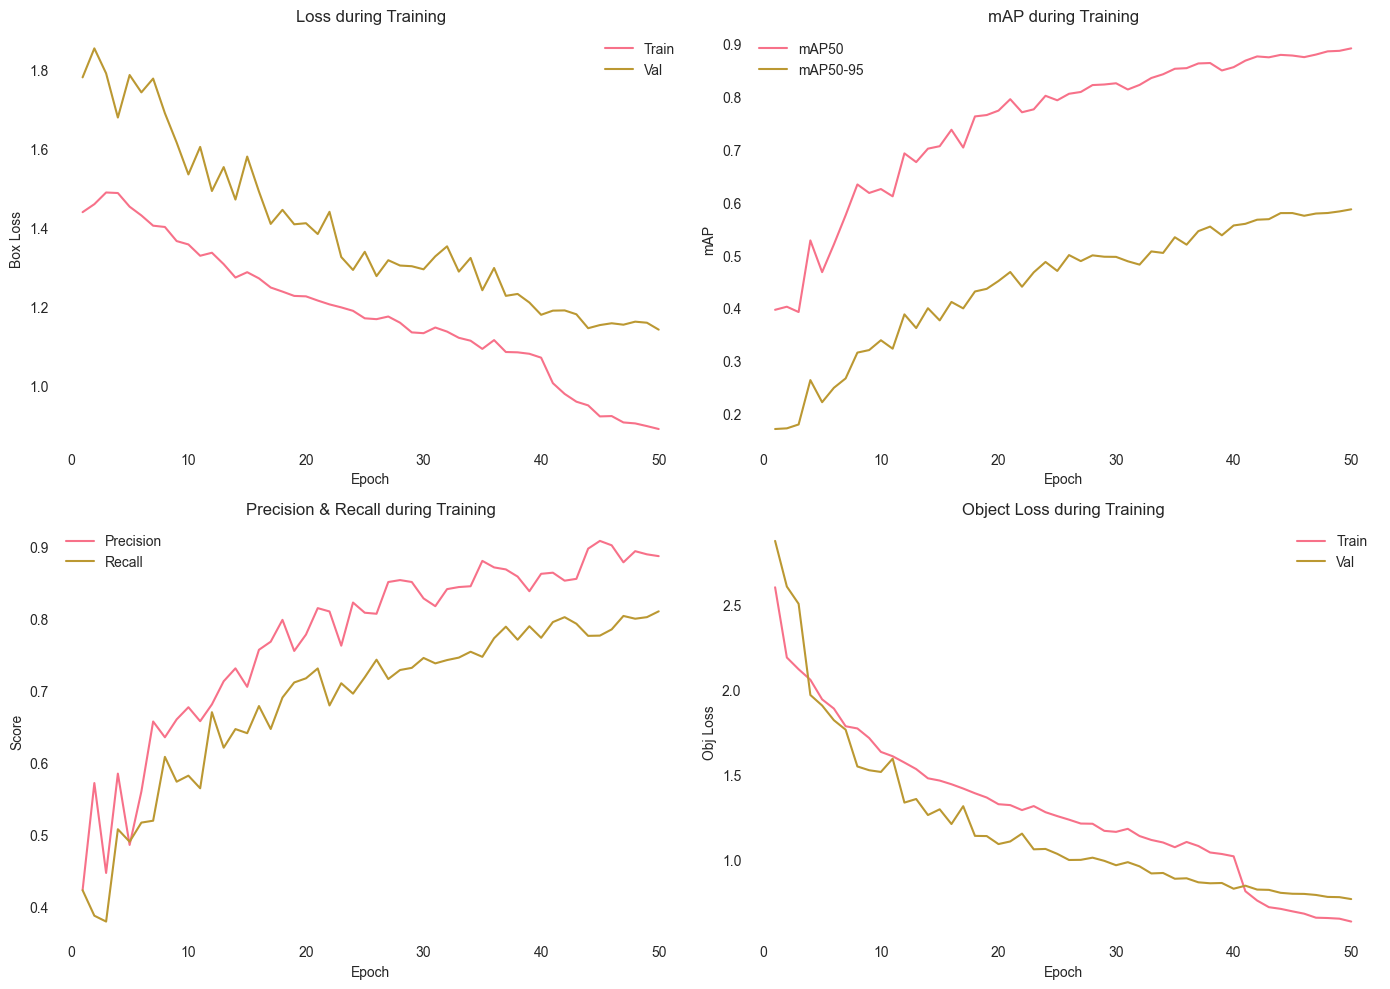


Графики обучения созданы


In [12]:

print("\n" + "=" * 70)
print("АНАЛИЗ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ")
print("=" * 70 + "\n")

# Загрузить результаты обучения
results_dir = MODELS_DIR / 'yolov8n_poacher_detector'
results_csv = results_dir / 'results.csv'

if results_csv.exists():
    results_df = pd.read_csv(results_csv)

    print("Итоговые метрики:")
    print(f"   mAP50: {results_df['metrics/mAP50(B)'].iloc[-1]:.4f}")
    print(f"   mAP50-95: {results_df['metrics/mAP50-95(B)'].iloc[-1]:.4f}")
    print(f"   Precision: {results_df['metrics/precision(B)'].iloc[-1]:.4f}")
    print(f"   Recall: {results_df['metrics/recall(B)'].iloc[-1]:.4f}")

    # Графики обучения
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Loss
    axes[0, 0].plot(results_df['epoch'], results_df['train/box_loss'], label='Train')
    axes[0, 0].plot(results_df['epoch'], results_df['val/box_loss'], label='Val')
    axes[0, 0].set_ylabel('Box Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend()
    axes[0, 0].grid()
    axes[0, 0].set_title('Loss during Training')

    # mAP
    axes[0, 1].plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP50')
    axes[0, 1].plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP50-95')
    axes[0, 1].set_ylabel('mAP')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend()
    axes[0, 1].grid()
    axes[0, 1].set_title('mAP during Training')

    # Precision & Recall
    axes[1, 0].plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision')
    axes[1, 0].plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend()
    axes[1, 0].grid()
    axes[1, 0].set_title('Precision & Recall during Training')

    # Object Confidence
    axes[1, 1].plot(results_df['epoch'], results_df['train/cls_loss'], label='Train')
    axes[1, 1].plot(results_df['epoch'], results_df['val/cls_loss'], label='Val')
    axes[1, 1].set_ylabel('Obj Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend()
    axes[1, 1].grid()
    axes[1, 1].set_title('Object Loss during Training')

    plt.tight_layout()
    plt.show()

    print("\nГрафики обучения созданы")

# ЧАСТЬ 8: ИНФОРМАЦИЯ О МОДЕЛИ


In [21]:

print("\n" + "=" * 70)
print("ИНФОРМАЦИЯ О ОБУЧЕННОЙ МОДЕЛИ")
print("=" * 70 + "\n")

if final_model_path.exists():
    model_size = final_model_path.stat().st_size / 1e6
    print(f"Размер модели: {model_size:.2f} МБ")
    print(f"Путь к модели: {final_model_path}")
    print(f"Модель готова к инференсу!")
    print(f"\nИспользование модели:")
    print(f"""
from ultralytics import YOLO

model = YOLO('{final_model_path}')
results = model.predict('path/to/image.jpg', conf=0.5)
    """)
else:
    print("Модель не найдена")

print("\n" + "=" * 70)
print("ОБУЧЕНИЕ ЗАВЕРШЕНО!")
print("=" * 70)
print("\nСледующий шаг:")
print("   Перейдите к ноутбуку: 03_evaluation_and_demo.ipynb")



ИНФОРМАЦИЯ О ОБУЧЕННОЙ МОДЕЛИ

Размер модели: 6.27 МБ
Путь к модели: ..\models\yolov8n_best.pt
Модель готова к инференсу!

Использование модели:

from ultralytics import YOLO

model = YOLO('..\models\yolov8n_best.pt')
results = model.predict('path/to/image.jpg', conf=0.5)
    

ОБУЧЕНИЕ ЗАВЕРШЕНО!

Следующий шаг:
   Перейдите к ноутбуку: 03_evaluation_and_demo.ipynb
